In [ ]:
import nltk
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from textblob import TextBlob
import requests
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('words')
stop_words = stopwords.words('english')
words = set(nltk.corpus.words.words())
nltk.download('punkt')
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
Train_file = "TRAIN_FILE.TXT"
Test_file = "TEST_FILE_FULL.TXT"


In [ ]:
def Load_corpus(path):
    temp_data = []
    lines = [line.strip() for line in open(path)] # strip to remove the whitespace
    for idx in range(0, len(lines), 4):
        id = lines[idx].split("\t")[0]
        relation = lines[idx + 1]

        sentence = lines[idx].split("\t")[1][1:-1]

        sentence = sentence.replace("<e1>", " _e1_ ").replace("</e1>", " _/e1_ ")
        sentence = sentence.replace("<e2>", " _e2_ ").replace("</e2>", " _/e2_ ")
        sentence = sentence.replace("<e1>", "<e1> ").replace("</e1>", " </e11>")
        sentence = sentence.replace("<e2>", "<e2> ").replace("</e2>", " </e22>")

        tokens = nltk.word_tokenize(sentence)
        tokens.remove('_/e1_')
        tokens.remove('_/e2_')

        e1 = tokens.index("_e1_")
        del tokens[e1]
        element1=tokens[e1]

        e2 = tokens.index("_e2_")
        del tokens[e2]
        element2=tokens[e2]

        sentence = " ".join(tokens)
        temp_data.append([id, sentence, e1, element1, e2, element2, relation])

    df = pd.DataFrame(data=temp_data, columns=["id", "sentence", "entity1_position","entity1", "entity2_position","entity2", "class"])
    #print (df)
    labelsMapping = {'Other': 0,
                     'Message-Topic(e1,e2)': 0,
                     'Message-Topic(e2,e1)': 0,
                     'Product-Producer(e1,e2)': 0,
                     'Product-Producer(e2,e1)': 0,
                     'Instrument-Agency(e1,e2)': 0,
                     'Instrument-Agency(e2,e1)': 0,
                     'Entity-Destination(e1,e2)': 2,
                     'Entity-Destination(e2,e1)': 2,
                     'Cause-Effect(e1,e2)': 3,
                     'Cause-Effect(e2,e1)': 3,
                     'Component-Whole(e1,e2)': 4,
                     'Component-Whole(e2,e1)': 4,
                     'Entity-Origin(e1,e2)': 1,
                     'Entity-Origin(e2,e1)': 1,
                     'Member-Collection(e1,e2)': 0,
                     'Member-Collection(e2,e1)': 0,
                     'Content-Container(e1,e2)': 0,
                     'Content-Container(e2,e1)': 0}

    df['tag'] = [labelsMapping[r] for r in df['class']]

    #print(df)
    x_sentence = df['sentence'].tolist()

    #Label Data
    y = df['tag']
    return df

In [ ]:
df=Load_corpus(Train_file)
df_test = Load_corpus(Test_file)

In [ ]:
# Replace the not needed train class entitites to other entities

df[['class']] = df[['class']].replace(['Member-Collection(e1,e2)'],['Other'])
df[['class']] = df[['class']].replace(['Member-Collection(e2,e1)'],['Other'])
df[['class']] = df[['class']].replace(['Instrument-Agency(e1,e2)'],['Other'])
df[['class']] = df[['class']].replace(['Instrument-Agency(e2,e1)'],['Other'])

df[['class']] = df[['class']].replace(['Content-Container(e1,e2)'],['Other'])
df[['class']] = df[['class']].replace(['Content-Container(e2,e1)'],['Other'])
df[['class']] = df[['class']].replace(['Message-Topic(e1,e2)'],['Other'])
df[['class']] = df[['class']].replace(['Message-Topic(e2,e1)'],['Other'])

df[['class']] = df[['class']].replace(['Product-Producer(e1,e2)'],['Other'])
df[['class']] = df[['class']].replace(['Product-Producer(e2,e1)'],['Other'])

# Print the data set of train class

#print(df[:5], file=open('ds_stats.txt', mode='w'))
df[:5]

,id,sentence,entity1_position,entity1,entity2_position,entity2,class,tag
0,1,The system as described above has its greatest...,12,configuration,15,elements,"Component-Whole(e2,e1)",4
1,2,The child was carefully wrapped and bound into...,1,child,9,cradle,Other,0
2,3,The author of a keygen uses a disassembler to ...,1,author,7,disassembler,Other,0
3,4,A misty ridge uprises from the surge .,2,ridge,6,surge,Other,0
4,5,The student association is the voice of the un...,1,student,2,association,Other,0


In [ ]:
# Replace the not needed test class entitites to other entities

df_test[['class']] = df_test[['class']].replace(['Member-Collection(e1,e2)'],['Other'])
df_test[['class']] = df_test[['class']].replace(['Member-Collection(e2,e1)'],['Other'])
df_test[['class']] = df_test[['class']].replace(['Instrument-Agency(e1,e2)'],['Other'])
df_test[['class']] = df_test[['class']].replace(['Instrument-Agency(e2,e1)'],['Other'])

df_test[['class']] = df_test[['class']].replace(['Content-Container(e1,e2)'],['Other'])
df_test[['class']] = df_test[['class']].replace(['Content-Container(e2,e1)'],['Other'])
df_test[['class']] = df_test[['class']].replace(['Message-Topic(e1,e2)'],['Other'])
df_test[['class']] = df_test[['class']].replace(['Message-Topic(e2,e1)'],['Other'])

df_test[['class']] = df_test[['class']].replace(['Product-Producer(e1,e2)'],['Other'])
df_test[['class']] = df_test[['class']].replace(['Product-Producer(e2,e1)'],['Other'])

# print the dataset of test class

#print(df_test[:5], file=open('ds_stats.txt', mode='a'))
df_test[:5]
#x.to_csv("test.csv")

,id,sentence,entity1_position,entity1,entity2_position,entity2,class,tag
0,8001,The most common audits were about waste and re...,3,audits,6,waste,Other,0
1,8002,The company fabricates plastic chairs .,1,company,4,chairs,Other,0
2,8003,The school master teaches the lesson with a st...,2,master,8,stick,Other,0
3,8004,The suspect dumped the dead body into a local ...,5,body,9,reservoir,"Entity-Destination(e1,e2)",2
4,8005,Avian influenza is an infectious disease of bi...,1,influenza,16,virus,"Cause-Effect(e2,e1)",3


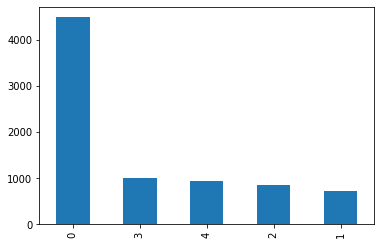

In [ ]:
# check the stats of the 'class' given training data set.
df['tag'].value_counts().plot(kind='bar')
#print(df['tag'].value_counts(), file=open('ds_stats.txt', mode='a'))

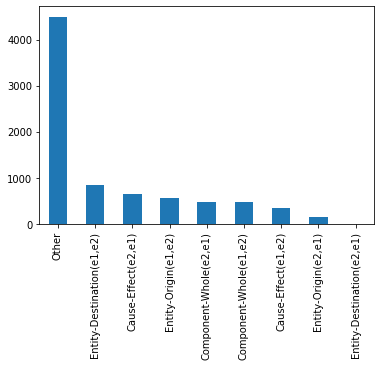

In [ ]:
# stat check for 'class' label
df['class'].value_counts().plot(kind='bar')
#print(df['class'].value_counts(), file=open('ds_stats.txt', mode='a'))

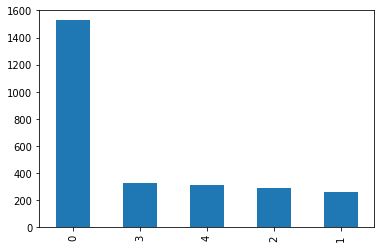

In [ ]:
# stat check for the 'tag label' in test class
df_test['tag'].value_counts().plot(kind='bar')
#print(df_test['tag'].value_counts(), file=open('ds_stats.txt', mode='a'))

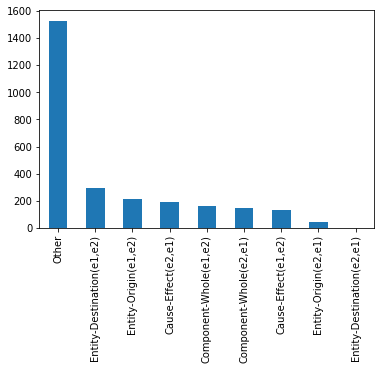

In [ ]:
# stats check for the class label in test dataset
df_test['class'].value_counts().plot(kind='bar')
#print(df_test['class'].value_counts(), file=open('ds_stats.txt', mode='a'))

In [ ]:


# preprocess the dataset
#sub() function is used to replace occurrences of a particular sub-string with another sub-string.
def preprocessor(sentence):
    sentence = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'\d+','', sentence)
    sentence = sentence.replace("user", "")
    return  sentence

In [ ]:
# apply preprocessing to clean the dataset
def clean_text(df):
    #This function acts as a map() function in Python. It takes a function as an input and applies this function to an entire DataFrame.
    train_cleaned = df['sentence'].apply(preprocessor)
    df['sentence'] = train_cleaned.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    return df
#print(df[:5],file=open('ds_stats.txt', mode='a'))
df[:5]

,id,sentence,entity1_position,entity1,entity2_position,entity2,class,tag
0,1,The system as described above has its greatest...,12,configuration,15,elements,"Component-Whole(e2,e1)",4
1,2,The child was carefully wrapped and bound into...,1,child,9,cradle,Other,0
2,3,The author of a keygen uses a disassembler to ...,1,author,7,disassembler,Other,0
3,4,A misty ridge uprises from the surge .,2,ridge,6,surge,Other,0
4,5,The student association is the voice of the un...,1,student,2,association,Other,0


In [ ]:
# function to cleaning the text
df['sentence'] = df['sentence'] + " " + df['entity1'] + " " + df['entity2']
df_test['sentence'] = df_test['sentence'] + " " + df_test['entity1'] + " " + df_test['entity2']
train_cleaned = clean_text(df)
test_cleaned = clean_text(df_test)

In [ ]:
data_str=df['sentence'].astype(str)
test_data_str=df_test['sentence'].astype(str)

# first get the vector features from count vectorixe then fit the vector form form data to learn the training data and this will return matrix values
train_counts = CountVectorizer().fit_transform(data_str)
# print the shape of traning dataset
print(train_counts.shape)


(8000, 19048)


In [ ]:
# load test and train file
df=Load_corpus(Train_file)
df_test = Load_corpus(Test_file)

#clean the file
train_cleaned = clean_text(df)
test_cleaned = clean_text(df_test)

# join the segments of the sentence
df['sentence'] = df['sentence'] + " " + df['entity1'] + " " + df['entity2']
df_test['sentence'] = df_test['sentence'] + " " + df_test['entity1'] + " " + df_test['entity2']

In [ ]:
# fit the train data matrix into transformer: learn the global term weights or the idf vector.
# term frequency - To mitigate the problem of weights comapiring to longer sentences-  #count(word) / #Total words
# tf-idf - term frequency times inverse document frequency- to reduce the weightage of more common words
tf_transformer = TfidfTransformer().fit(train_counts)

# Transform: a count matrix to a tf or tf-idf representation.
tf_train = tf_transformer.transform(train_counts)
print (tf_train.shape)

(8000, 19048)


In [ ]:
# fit the data then transform the data.
tf_idf_train = TfidfTransformer().fit_transform(train_counts)
print (tf_idf_train.shape)

(8000, 19048)


In [ ]:
# tag value of train and test data
train_data_mat = df['tag'].values
test_data_mat = df_test['tag'].values

In [ ]:
# define pipeline
text_classification = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,3))),
                                ('tfidftransformer', TfidfTransformer(use_idf=False)),
                                ('classification', SGDClassifier( loss='squared_hinge',penalty='l2',alpha=0.00038, random_state=50))])

In [ ]:
# fit the model
svm_prediction = text_classification.fit(data_str, train_data_mat).predict(test_data_str)

In [ ]:
# get the Accuracy
svm_accuracy = np.mean(svm_prediction == test_data_mat)
print("Support Vector Machine Model Accuracy={} %".format(svm_accuracy*100))

Support Vector Machine Model Accuracy=77.21751932278248 %


In [ ]:
# Create confusion matrix
mat = confusion_matrix(svm_prediction, test_data_mat)

In [ ]:
Accuracy_Score = accuracy_score(svm_prediction, test_data_mat)
Precision_Score = precision_score(svm_prediction, test_data_mat,  average="macro")
Recall_Score = recall_score(svm_prediction, test_data_mat,  average="macro")
F1_Score = f1_score(svm_prediction, test_data_mat,  average="macro")

In [ ]:
print('Accuracy: ', Accuracy_Score)
print('Precesion: ', Precision_Score)
print('Recall: ', Recall_Score)
print('F1: ', F1_Score)

Accuracy:  0.7721751932278248
Precesion:  0.6907540998169993
Recall:  0.7623395734364771
F1:  0.7108317821894714


In [ ]:
print('confusion matrix: \n', mat)

confusion matrix: 
 [[1329   78   69   46  172]
 [  71  166    0   18    6]
 [  86    7  220    0   11]
 [  18    3    1  262    2]
 [  23    4    2    2  121]]


In [ ]:
# get the classification report.
print(classification_report(svm_prediction, test_data_mat, digits=3))

              precision    recall  f1-score   support

           0      0.870     0.785     0.825      1694
           1      0.643     0.636     0.640       261
           2      0.753     0.679     0.714       324
           3      0.799     0.916     0.853       286
           4      0.388     0.796     0.522       152

    accuracy                          0.772      2717
   macro avg      0.691     0.762     0.711      2717
weighted avg      0.800     0.772     0.780      2717



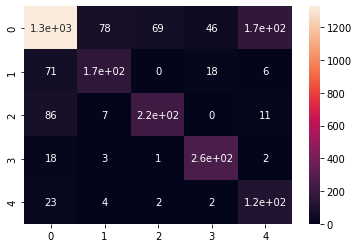

In [ ]:
# confusion matrix visualization.
import seaborn as sns
cf = confusion_matrix(svm_prediction, test_data_mat)
sns.heatmap(cf, annot=True)

In [ ]:
# check for the 50 test sentences-

label_map = {0: "Other", 1: "Entity-Origin", 2: 'Entity-Destination', 3: 'Cause-Effect', 4: 'Component-Whole'}

test_sentences = list(df_test['sentence'])
tags = list(df_test['tag'])
test_s = []
test_tag = []
for tag,sentence in zip(tags[:50],test_sentences[:50]):
  t = [sentence]
  test_tag.append(tag)
  test_s.append(t)

# print(test_tag, test_s)
# test_sent = np.array(test_sent)
preds = []
pred_sentence = []
for i in range(len(test_s)):
  test_pred = text_classification.predict(test_s[i])
  test_pred_class = label_map[test_pred[0]]
  preds.append(test_pred[0])
  pred_sentence.append(test_pred_class)

#print(len(preds))
for p in preds:
  print(p)


0
0
0
2
3
4
0
0
0
0
2
0
2
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
3
0
0
3
0
4
0
0
0
3
0
0
0
2
1
0
0
2
0
0


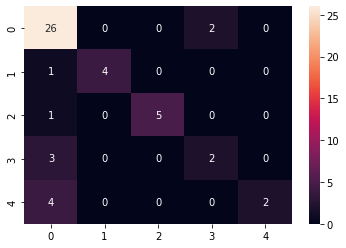

In [ ]:
# confusion matrix visualization on 50 test sentences
import seaborn as sns
cf = confusion_matrix(test_tag, preds)
sns.heatmap(cf, annot=True)

In [ ]:
# get the Classification Matrix.
print(classification_report(test_tag, preds))

              precision    recall  f1-score   support

           0       0.74      0.93      0.83        28
           1       1.00      0.80      0.89         5
           2       1.00      0.83      0.91         6
           3       0.50      0.40      0.44         5
           4       1.00      0.33      0.50         6

    accuracy                           0.78        50
   macro avg       0.85      0.66      0.71        50
weighted avg       0.81      0.78      0.76        50



In [ ]:
# Confusion Matrix for the test sentences.
cf

array([[26,  0,  0,  2,  0],
       [ 1,  4,  0,  0,  0],
       [ 1,  0,  5,  0,  0],
       [ 3,  0,  0,  2,  0],
       [ 4,  0,  0,  0,  2]])

In [ ]:
# to test the sentences-

label_map = {0: "Other", 1: "Entity-Origin", 2: 'Entity-Destination', 3: 'Cause-Effect', 4: 'Component-Whole'}

test_sent = ["We have delivered <e1>containers</e1> to <e2>retail stores</e2> for excess of inventory."]

for i in range(len(test_sent)):

    test_pred = text_classification.predict(test_sent)
    test_pred_class = label_map[test_pred[0]]
    print(test_pred_class)

Entity-Destination


In [ ]:
# to test the sentences-

label_map = {0: "Other", 1: "Entity-Origin", 2: 'Entity-Destination', 3: 'Cause-Effect', 4: 'Component-Whole'}

test_sent = ["The <e1>inflammation</e1> causes <e2>pain</e2> in the joint."]

for i in range(len(test_sent)):

    test_pred = text_classification.predict(test_sent)
    test_pred_class = label_map[test_pred[0]]
    print(test_pred_class)

Cause-Effect
